In [2]:
from math import log
import math
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from astronomical_matching.utils import neg_log_bayes, stirling2
from gurobipy import GRB, Model, quicksum
import pandas as pd
import time
from astronomical_matching.cop_kmeans import run_cop_kmeans
from astronomical_matching.kmeans import run_kmeans
from astronomical_matching.dirilp import setup_dirilp, dirilp
from astronomical_matching.miqcp import setup_miqcp_model, find_max_clusters, miqcp
from astronomical_matching.chainbreaker import chain_breaking
from astronomical_matching.simulate import simulate_two_objects, simulate_objects_on_circle
import itertools
from tqdm import tqdm
import astronomical_matching.constants as constants
from scipy.spatial.distance import pdist
from collections import defaultdict

plt.rcParams['text.usetex'] = True

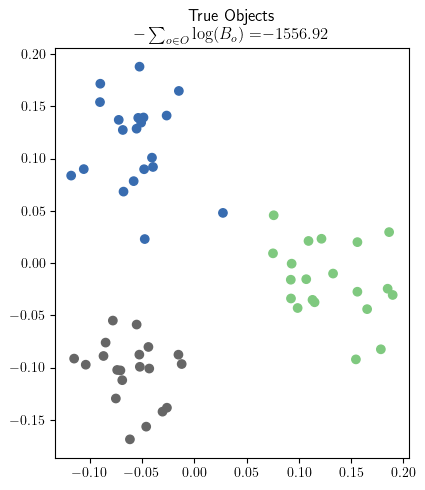

In [27]:
cats = 20
sigma = 0.04
radius = 0.12
seed = 1
num_objects = 3

df = simulate_objects_on_circle(sigma=sigma,
                                radius=radius,
                                num_objects=num_objects,
                                num_sources=cats,
                                seed=seed)

plt.figure(figsize=(5,5))
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=df.ObjectID, cmap="Accent")
plt.title(
    "True Objects\n"
    r"$-\sum_{{o\in O}}\log(B_o)=$"
    f"${neg_log_bayes(df,df.ObjectID):.2f}$"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")

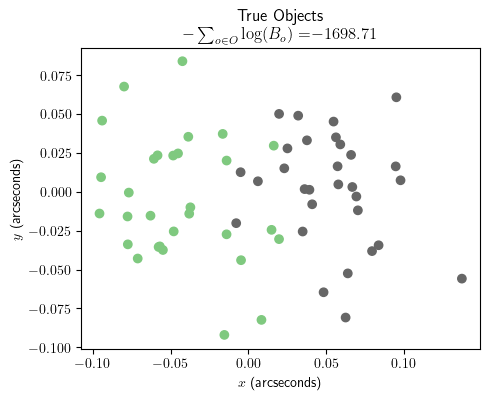

In [9]:
cats = 30
sigma1 = 0.04
sigma2 = 0.04
distance = 0.10
seed = 1

df = simulate_two_objects(
    sigma1=sigma1, sigma2=sigma2, distance=distance, num=cats, seed=seed
)
plt.figure(figsize=(5, 5))
plt.title(
    "True Objects\n"
    r"$-\sum_{{o\in O}}\log(B_o)=$"
    f"${neg_log_bayes(df,df.ObjectID):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=df.ObjectID, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig(f"figures/presentation/true_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

In [28]:
def setup_miqcp_model_2(data_df, max_clusters=-1, min_clusters=0, verbose=False):
    num_datapoints = data_df.shape[0]
    num_clusters = max_clusters
    if max_clusters == -1:
        num_clusters = num_datapoints
    num_catalogs = data_df["ImageID"].unique().shape[0]
    dims = 2

    C = np.log(
        constants.ARCSEC_TO_RAD_2
    )  # constant used for arcseconds to radians conversion

    model = Model("MIQCP")
    if not verbose:
        model.setParam("OutputFlag", 0)

    # Make intermediate lists and dictionaries
    candidate_list = []
    coord_dict = dict()
    kappa_dict = dict()

    for _, row in data_df.iterrows():
        source_image = (row.SourceID, row.ImageID)
        candidate_list.append(source_image)
        coord_dict[source_image] = (
            row["coord1 (arcseconds)"],
            row["coord2 (arcseconds)"],
        )
        kappa_dict[source_image] = row["kappa"]

    # Add cluster variables
    cluster_vars = model.addVars(num_clusters, dims, lb=-float("inf"), ub=float("inf"))

    # Add boolean variables (cluster-sources)
    x = model.addVars(
        candidate_list, list(range(num_clusters)), vtype=GRB.BINARY, name="x"
    )

    for (source, catalog, k), var in x.items():
        var.setAttr("BranchPriority", 1)

    # Number of clusters
    p = model.addVars(num_clusters, lb=0, vtype=GRB.BINARY)

    # Add M variable
    M = (
        np.max(pdist(data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]))
        * data_df["kappa"].max()
        * 1.1
    )
    # M = 10**6

    # Add max cluster distance variables
    r_dict = model.addVars(candidate_list, lb=0.0, ub=float("inf"))

    # Log term
    error_threshold = 1 / 10 * np.log(data_df["kappa"].min())

    var_chi_dict = {}
    sigma_max = data_df["Sigma"].max()
    sigma_min = data_df["Sigma"].min()

    # b_list = [np.log(1/(sigma_max)**2) + C]
    # b_list = [np.log(1/(sigma_max)**2)]
    b_list = [(-2) * np.log(sigma_max)]
    # Compute b_list
    # while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2) + C:
    while b_list[-1] < np.log(num_catalogs) - (2 * np.log((sigma_min))):
        b_list.append(b_list[-1] + error_threshold)

    num_breakpoints = len(b_list)  # = P in the paper

    # Variables for chi
    for j in range(num_clusters):
        for b_i in range(num_breakpoints):
            var_chi_dict[("chi", j, b_i)] = model.addVar(
                vtype=GRB.BINARY, name=str(("chi", j, b_i))
            )

    s = model.addVars(num_clusters, lb=0, vtype=GRB.INTEGER)

    # Add Stirling number variables
    stirling_vars = model.addVars(range(1, num_clusters + 1), lb=0)
    z = model.addVars(range(1, num_clusters + 1), lb=0, vtype=GRB.BINARY)

    ### Objective ###
    sum_ln_kappa_rad = (C * num_datapoints) + np.log(data_df["kappa"]).sum()
    model.setObjective(
        (0.5 * r_dict.sum())
        + (np.log(2) * p.sum())
        - (np.log(2) * s.sum())
        + quicksum(
            (b_list[0] * var_chi_dict[("chi", j, 0)])
            + (
                error_threshold
                * quicksum(
                    var_chi_dict[("chi", j, b_i)] for b_i in range(1, num_breakpoints)
                )
            )
            for j in range(num_clusters)
        )
        + (p.sum() * C)
        - sum_ln_kappa_rad
        + stirling_vars.sum(),
        GRB.MINIMIZE,
    )

    ### Constraints
    # Each point assigned to a cluster
    for source, catalog in candidate_list:
        model.addConstr(
            quicksum(x[(source, catalog, j)] for j in range(num_clusters)) == 1
        )

    # |# objects|
    # p = 1 if there is a source in that cluster
    # p = 0 if no sources assigned to cluster
    for j in range(num_clusters):
        for source, catalog in candidate_list:
            model.addConstr(p[j] >= x[source, catalog, j])

    # lower bound on objects for getting a maximum object count
    model.addConstr(p.sum() >= min_clusters)

    # |# sources| * ln(2)
    for j in range(num_clusters):
        model.addConstr(
            s[j]
            == quicksum(x[source, catalog, j] for source, catalog in candidate_list)
        )

    # Each cluster has at most one source from a catalog
    sources_by_catalog = defaultdict(list)
    for source, catalog in candidate_list:
        sources_by_catalog[catalog].append(source)

    for j, c in itertools.product(range(num_clusters), range(num_catalogs)):
        model.addConstr(
            quicksum(x[(source, c, j)] for source in sources_by_catalog[c]) <= 1
        )

    # Min and max for cluster variables
    # Get coordinates
    x_coords = data_df["coord1 (arcseconds)"]
    y_coords = data_df["coord2 (arcseconds)"]

    for j in range(num_clusters):
        model.addConstr(cluster_vars[j, 0] == [min(x_coords), max(x_coords)])
        model.addConstr(cluster_vars[j, 1] == [min(y_coords), max(y_coords)])

    # Break symmetry
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1)

    # Big-M constraints
    for (source, catalog), coord in coord_dict.items():
        for j in range(num_clusters):
            model.addQConstr(
                (
                    kappa_dict[(source, catalog)]
                    * (  # in arcseconds^-2
                        (
                            (cluster_vars[j, 0] - coord[0])
                            * (cluster_vars[j, 0] - coord[0])
                        )
                        + (
                            (cluster_vars[j, 1] - coord[1])
                            * (cluster_vars[j, 1] - coord[1])
                        )
                    )
                )  # in arcseconds ^ 2
                <= r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)]))
            )

    # Stirling number vars
    M2 = math.log(stirling2(num_datapoints, num_clusters)) * 2

    model.addConstr(z.sum() == 1)

    for j in range(1, num_clusters + 1):
        model.addConstr(p.sum() <= j * z[j] + num_clusters * (1 - z[j]))
        model.addConstr(p.sum() >= j * z[j])

        model.addConstr(
            stirling_vars[j] - math.log(stirling2(num_datapoints, j)) <= M2 * (1 - z[j])
        )
        model.addConstr(
            stirling_vars[j] - math.log(stirling2(num_datapoints, j))
            >= -M2 * (1 - z[j])
        )

    # Definition of variables chi
    # Equation B19
    for j in range(num_clusters):
        chi_constraint_with_b = []
        chi_constraint = []
        x_constraint = []
        for breakpoint_index in range(1, num_breakpoints):
            chi_constraint_with_b.append(
                var_chi_dict[("chi", j, breakpoint_index)]
                * (
                    np.exp(b_list[breakpoint_index])
                    - np.exp(b_list[breakpoint_index - 1])
                )
            )
        for source, catalog in candidate_list:
            x_constraint.append(x[(source, catalog, j)] * kappa_dict[(source, catalog)])
        model.addConstr(
            np.exp(b_list[0]) * var_chi_dict[("chi", j, 0)]
            + quicksum(variable for variable in chi_constraint_with_b)
            >= quicksum(variable for variable in x_constraint)
        )

        for breakpoint_index in range(num_breakpoints):
            chi_constraint.append(var_chi_dict[("chi", j, breakpoint_index)])
        for chi_index in range(len(chi_constraint) - 1):
            model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])

    model.setParam("NumericFocus", 2)  # for numerical stability
    model.setParam("NodefileStart", 2.0)

    return model, x, stirling_vars, p, z


model, x, stirling_vars, p, z = setup_miqcp_model_2(
    df, max_clusters=5, min_clusters=0, verbose=True
)
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Set parameter NumericFocus to value 2
Set parameter NodefileStart to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 528 rows, 430 columns and 1995 nonzeros
Model fingerprint: 0x2c0e852f
Model has 300 quadratic constraints
Variable types: 85 continuous, 345 integer (340 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  QMatrix range    [6e+02, 6e+02]
  QLMatrix range   [6e-01, 3e+02]
  Objective range  [5e-01, 3e+01]
  Bounds range     [3e-01, 1e+00]
  RHS range        [2e-01, 3e+02]
  QRHS range       [2e+02, 3e+02]
Presolve removed 24 rows and 15 columns
Presolve time: 0.01s
Presolved: 504 rows, 415 columns, 2605 nonzeros
Presolved model has 5 quadratic constraint(s)
Variable types: 85 continuous, 330 integer (330 binary)

Root re

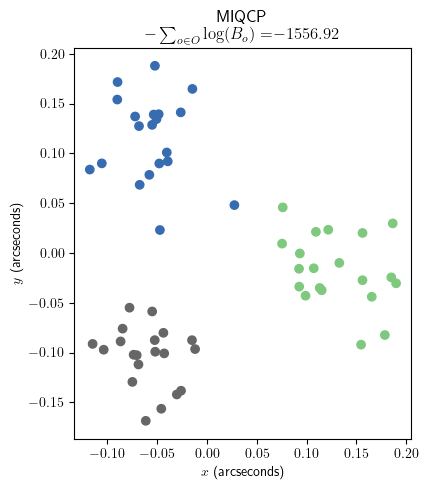

In [29]:
# labels = miqcp(data_df = df, verbose = False, preDual = False, preQLinearize = False)

labels = []
for (_, _, j), var in x.items():
    if var.X > 0.5:
        labels.append(j)

labels = pd.factorize(labels)[0]  # factorize sets labels from 0 to max_labels

plt.figure(figsize=(5, 5))
plt.title("MIQCP\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig(f"figures/presentation/miqcp_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

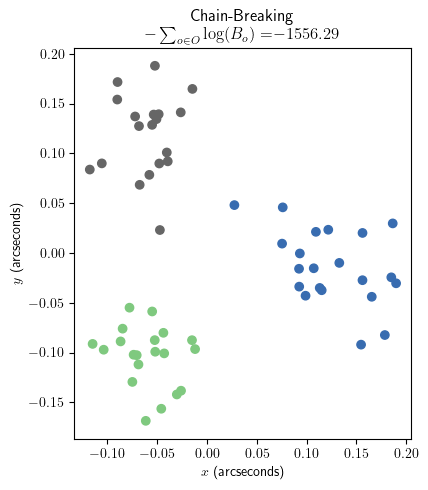

In [30]:
labels, _, _ = chain_breaking(df)

plt.figure(figsize=(5, 5))
plt.title(
    "Chain-Breaking\n"
    r"$-\sum_{{o\in O}}\log(B_o)=$"
    f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig(f"figures/presentation/chain-breaking_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

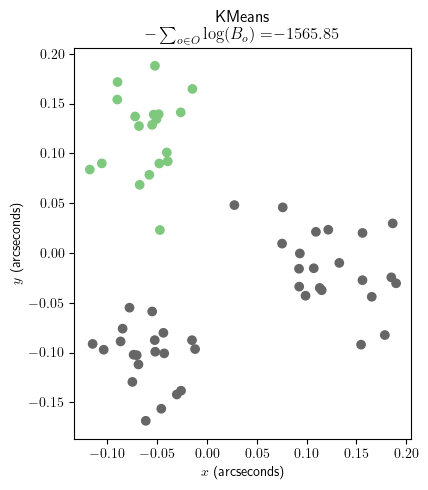

In [31]:
labels, _, _ = run_kmeans(df, min_k=1, max_k=10)

plt.figure(figsize=(5, 5))
plt.title(
    "KMeans\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")

100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


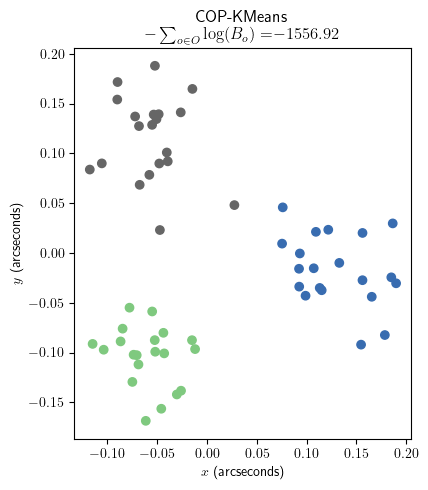

In [32]:
labels, _, _ = run_cop_kmeans(df, min_k=1, max_k=10, num_repeat=5, verbose=True)

plt.figure(figsize=(5, 5))
plt.title(
    "COP-KMeans\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig(f"figures/presentation/cop-kmeans_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

In [3]:
from functools import partial
from typing import Union
from func_timeout import func_timeout, FunctionTimedOut


def time_method(df: pd.DataFrame, method, repeat: int = 1):
    """Time a method.

    Args:
        df (pd.DataFrame): dataframe with coordinates and uncertainties
        method (function): method to run
        repeat (int, optional): number of time repeats. Defaults to 5.

    Returns:
        list: list of runtimes
    """
    times = []

    for _ in range(repeat):
        time_spent = 0
        try:
            start_time = time.perf_counter()

            func_timeout(2700, method, args=(df,))
            end_time = time.perf_counter()
            time_spent = end_time - start_time
        except FunctionTimedOut:
            time_spent = 1000000000

        times.append(time_spent)
    return times


def log_runtimes(
    filename: str,
    distances: Union[list[float], float],
    num_cats: Union[list[float], float],
    sigma1s: Union[list[float], float],
    sigma2s: Union[list[float], float],
    repeats: int,
):
    pd_dict = {
        "distance": [],
        "number of catalogs": [],
        "sigma 1": [],
        "sigma 2": [],
        "miqcp runtimes": [],
        "dirilp runtimes": [],
    }
    if type(distances) == float:
        distances = [distances]
    if type(num_cats) == float:
        num_cats = [num_cats]
    if type(sigma1s) == float:
        sigma1s = [sigma1s]
    if type(sigma2s) == float:
        sigma2s = [sigma2s]
    for d, n, s1, s2 in itertools.product(distances, num_cats, sigma1s, sigma2s):
        print(d, n, s1, s2)
        pd_dict["distance"].append(d)
        pd_dict["number of catalogs"].append(n)
        pd_dict["sigma 1"].append(s1)
        pd_dict["sigma 2"].append(s2)
        miqcp_times = []
        dirilp_times = []
        for seed in range(repeats):
            df = simulate_two_objects(
                sigma1=s1, sigma2=s2, distance=d, num=n, seed=seed
            )
            miqcp_time = time_method(df, miqcp, repeat=1)
            dirilp_time = time_method(df, dirilp, repeat=1)
            miqcp_times.append(miqcp_time[0])
            dirilp_times.append(dirilp_time[0])
        pd_dict["miqcp runtimes"].append(miqcp_times)
        pd_dict["dirilp runtimes"].append(dirilp_times)

    df_times = pd.DataFrame(pd_dict)
    df_times.to_csv(filename)

In [5]:
log_runtimes(
    "runtimes3.csv", 0.13, [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 0.04, 0.04, 5
)

0.13 2 0.04 0.04
0.13 5 0.04 0.04
0.13 10 0.04 0.04
0.13 15 0.04 0.04
0.13 20 0.04 0.04
0.13 25 0.04 0.04


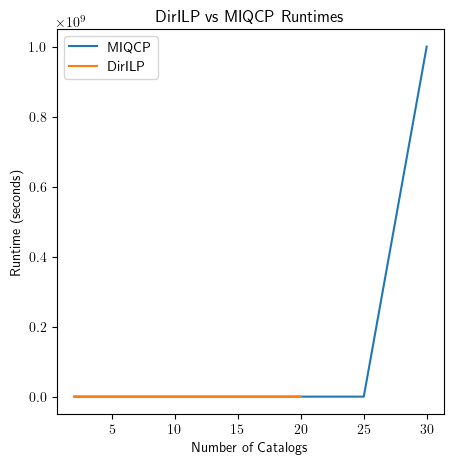

In [40]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip("][").split(", ") for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip("][").split(", ") for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5, 5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"], miqcp_runtimes)
plt.plot(runtimes["number of catalogs"], dirilp_runtimes)
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_long.svg")

In [2]:
def get_percent_solved(arr):
    count = 0
    for a in arr:
        if a == 1000000000:
            count += 1
    return 100 * (1 - (count / len(arr)))


def filtered_mean_std(arr):
    arr = np.array(arr)
    arr = np.delete(arr, np.where(arr == 1000000000))
    return np.mean(arr), np.std(arr)

In [39]:
runtimes_long = pd.read_csv("runtimes3.csv", index_col=0)
cat_list = runtimes_long["number of catalogs"].unique()
miqcp_runtimes = (
    runtimes_long.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()
)
dirilp_runtimes = (
    runtimes_long.groupby("number of catalogs")["dirilp runtime"].apply(list).to_dict()
)

miqcp_percent_solved = {k: get_percent_solved(v) for k, v in miqcp_runtimes.items()}
dirilp_percent_solved = {k: get_percent_solved(v) for k, v in dirilp_runtimes.items()}

miqcp_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_runtimes.items()}
dirilp_mean_std = {k: filtered_mean_std(v) for k, v in dirilp_runtimes.items()}

/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
def plot_runtimes_error(rundict):
    x = list(rundict.keys())
    means = [v[0] for v in rundict.values()]
    stds = [v[1] for v in rundict.values()]

    plt.yscale("log")
    plt.errorbar(x, means, yerr=stds)

In [ ]:
plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plot_runtimes_error(dirilp_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("runtime_long.svg")

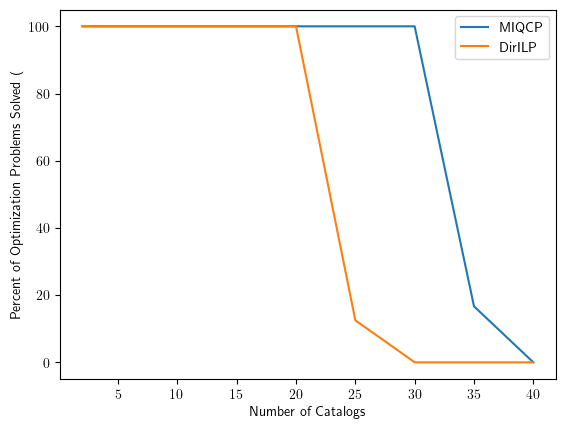

In [58]:
plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Percent of Optimization Problems Solved (%)")
cats = list(miqcp_percent_solved.keys())
plt.plot(cats, [v for v in miqcp_percent_solved.values()])
plt.plot(cats, [v for v in dirilp_percent_solved.values()])
plt.legend(["MIQCP", "DirILP"])
plt.savefig("percent_solved_long.svg")

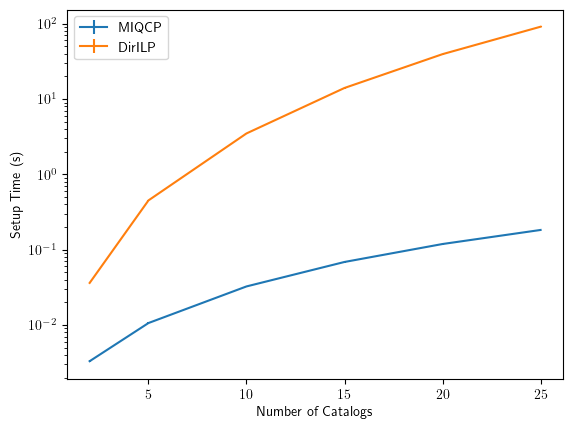

In [60]:
setuptimes = pd.read_csv("setuptime1.csv", index_col=0)
cat_list = setuptimes["number of catalogs"].unique()
miqcp_setup = (
    setuptimes.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()
)
dirilp_setup = (
    setuptimes.groupby("number of catalogs")["dirilp runtime"].apply(list).to_dict()
)

miqcp_setup_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_setup.items()}
dirilp_setup_mean_std = {k: filtered_mean_std(v) for k, v in dirilp_setup.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Setup Time (s)")
plot_runtimes_error(miqcp_setup_mean_std)
plot_runtimes_error(dirilp_setup_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("setuptimes.svg")

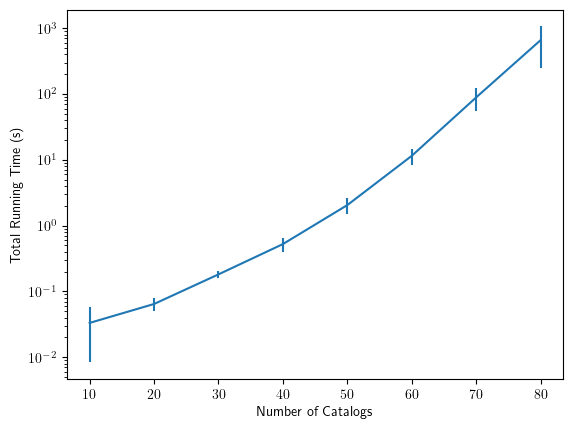

In [5]:
times = pd.read_csv("runtime-capped.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
miqcp_run = times.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()

miqcp_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plt.savefig("capped-runtime.svg")

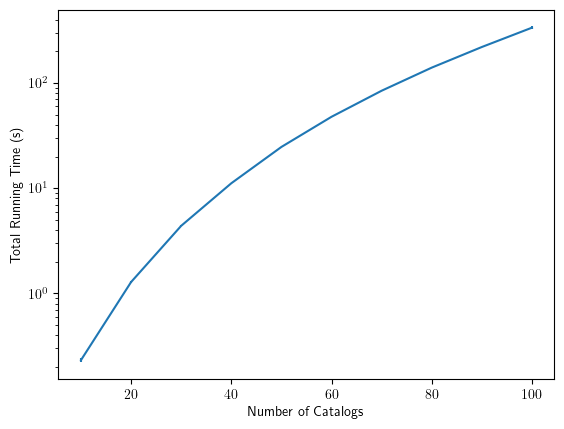

In [4]:
times = pd.read_csv("runtime-copkmeans.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
miqcp_run = times.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()

miqcp_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plt.savefig("capped-copkmeans.svg")

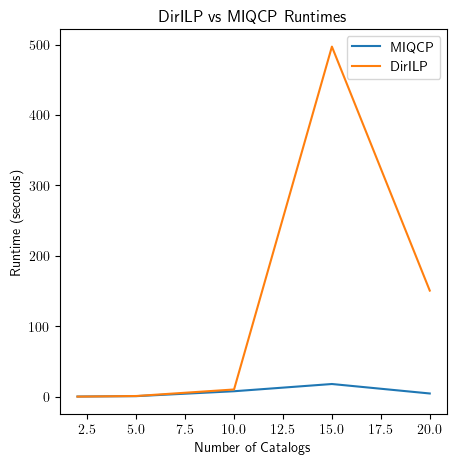

In [42]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip("][").split(", ") for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip("][").split(", ") for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5, 5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"][:-2], miqcp_runtimes[:-2])
plt.plot(runtimes["number of catalogs"][:-2], dirilp_runtimes[:-2])
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_short_2.svg")